<a href="https://colab.research.google.com/github/Ken-Lau-Lab/single-cell-lectures/blob/main/section03_dimension_reduction_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __Section 3:__ Dimension Reduction & Structural Preservation Analysis

February 22, 2022

In [ ]:
!git clone git://github.com/Ken-Lau-Lab/single-cell-lectures

In [ ]:
!pip install -r single-cell-lectures/requirements.txt

In [1]:
%env PYTHONHASHSEED=0
import scanpy as sc 
import numpy as np
from sklearn.preprocessing import normalize

env: PYTHONHASHSEED=0


In [2]:
sc.settings.verbosity = 3 #Set scanpy verbosity to 3 for in depth function run information

In [3]:
import random
np.random.seed(22)
random.seed(22)

---
### __0.__ Define Convenience Functions

In [16]:
# define cell cycle phase genes
#  human genes ('_h') from satija lab list
s_genes_h = [
    "MCM5",
    "PCNA",
    "TYMS",
    "FEN1",
    "MCM2",
    "MCM4",
    "RRM1",
    "UNG",
    "GINS2",
    "MCM6",
    "CDCA7",
    "DTL",
    "PRIM1",
    "UHRF1",
    "MLF1IP",
    "HELLS",
    "RFC2",
    "RPA2",
    "NASP",
    "RAD51AP1",
    "GMNN",
    "WDR76",
    "SLBP",
    "CCNE2",
    "UBR7",
    "POLD3",
    "MSH2",
    "ATAD2",
    "RAD51",
    "RRM2",
    "CDC45",
    "CDC6",
    "EXO1",
    "TIPIN",
    "DSCC1",
    "BLM",
    "CASP8AP2",
    "USP1",
    "CLSPN",
    "POLA1",
    "CHAF1B",
    "BRIP1",
    "E2F8",
]
g2m_genes_h = [
    "HMGB2",
    "CDK1",
    "NUSAP1",
    "UBE2C",
    "BIRC5",
    "TPX2",
    "TOP2A",
    "NDC80",
    "CKS2",
    "NUF2",
    "CKS1B",
    "MKI67",
    "TMPO",
    "CENPF",
    "TACC3",
    "FAM64A",
    "SMC4",
    "CCNB2",
    "CKAP2L",
    "CKAP2",
    "AURKB",
    "BUB1",
    "KIF11",
    "ANP32E",
    "TUBB4B",
    "GTSE1",
    "KIF20B",
    "HJURP",
    "CDCA3",
    "HN1",
    "CDC20",
    "TTK",
    "CDC25C",
    "KIF2C",
    "RANGAP1",
    "NCAPD2",
    "DLGAP5",
    "CDCA2",
    "CDCA8",
    "ECT2",
    "KIF23",
    "HMMR",
    "AURKA",
    "PSRC1",
    "ANLN",
    "LBR",
    "CKAP5",
    "CENPE",
    "CTCF",
    "NEK2",
    "G2E3",
    "GAS2L3",
    "CBX5",
    "CENPA",
]

def cc_score(adata, layer=None, seed=18, verbose=True):
    """
    Calculates cell cycle scores and implied phase for each observation

    Parameters
    ----------

    adata : anndata.AnnData
        object containing transformed and normalized (arcsinh or log1p) counts in 
        'layer'.
    layer : str, optional (default=None)
        key from adata.layers to use for cc phase calculation. Default None to 
        use .X
    seed : int, optional (default=18)
        random state for PCA, neighbors graph and clustering
    verbose : bool, optional (default=True)
        print updates to console

    Returns
    -------

    adata is edited in place to add 'G2M_score', 'S_score', and 'phase' to .obs
    """
    if layer is not None:
        adata.layers["temp"] = adata.X.copy()
        adata.X = adata.layers[layer].copy()
        if verbose:
            print("Calculating cell cycle scores using layer: {}".format(layer))
    else:
        if verbose:
            print("Calculating cell cycle scores")
    # determine if sample is mouse or human based on gene names
    if any(item in adata.var_names for item in s_genes_h + g2m_genes_h):
        s_genes, g2m_genes = s_genes_h, g2m_genes_h
    elif any(item in adata.var_names for item in s_genes_m + g2m_genes_m):
        s_genes, g2m_genes = s_genes_m, g2m_genes_m
    # score cell cycle using scanpy function
    sc.tl.score_genes_cell_cycle(
        adata,
        s_genes=s_genes,  # defined at top of script
        g2m_genes=g2m_genes,  # defined at top of script
        random_state=seed,
    )
    if layer is not None:
        adata.X = adata.layers["temp"].copy()
        del adata.layers["temp"]

def arcsinh_norm(adata, layer=None, norm="l1", scale=1000):
    """
    return arcsinh-normalized values for each element in anndata counts matrix
    l1 normalization (sc.pp.normalize_total) should be performed before this transformation
        adata = AnnData object
        layer = name of lauer to perform arcsinh-normalization on. if None, use AnnData.X
        norm = normalization strategy prior to Log2 transform.
            None: do not normalize data
            'l1': divide each count by sum of counts for each cell
            'l2': divide each count by sqrt of sum of squares of counts for cell
        scale = factor to scale normalized counts to; default 1000
    """
    if layer is None:
        mat = adata.X
    else:
        mat = adata.layers[layer]

    adata.layers["arcsinh_norm"] = np.arcsinh(normalize(mat, axis=1, norm=norm) * scale)

---
### __1.__ Preprocessing & Cell Metadata Generation

[`AnnData`](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html) objects can be read straight from a compressed `.h5ad` file, containing metadata and reduced dimensions.

Here, we will read in a manually-filtered `.h5ad` file for our human colonic mucosa data.

In [17]:
adata = sc.read("single-cell-lectures/data/Filtered_TNP_Data.h5ad") ; adata

AnnData object with n_obs × n_vars = 2176 × 29426

Now we can calculate some QC metrics and preprocess the raw counts by __normalizing per cell__ and __arcsinh-transforming__.

In [18]:
# get useful metrics of counts data
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
adata.layers["raw_counts"] = adata.X.copy()  # save raw counts in layer
arcsinh_norm(adata, layer="raw_counts", norm="l1", scale=1000)  # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
adata.X = adata.layers["arcsinh_norm"].copy()  # set normalized counts as .X slot in scanpy object

# since we prefer arcsinh over log1p, let's get some arcsinh-transformed metrics as well
adata.obs["arcsinh_total_counts"] = np.arcsinh(adata.obs["total_counts"])
adata.obs["arcsinh_n_genes_by_counts"] = np.arcsinh(adata.obs["n_genes_by_counts"])

# see resulting AnnData contents
adata

AnnData object with n_obs × n_vars = 2176 × 29426
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'arcsinh_total_counts', 'arcsinh_n_genes_by_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [19]:
cc_score(adata, layer="arcsinh_norm", seed=18, verbose=True)

calculating cell cycle phase
computing score 'S_score'


Calculating cell cycle scores using layer: arcsinh_norm


    finished: added
    'S_score', score of gene set (adata.obs).
    340 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    427 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


We can use `sc.pp.highly_variable_genes` to identify HVGs in our dataset to be used for PCA and downstream analysis.

In [20]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


---
### __2.__ Dimension Reduction

Now we can perform an initial dimension reduction with __principal component analysis__. This dimension-reduced __native space__ will be used to generate further low-dimensional projections with __t-SNE__ and __UMAP__ (__latent spaces__), becoming the reference for our data structure preservation analysis.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
... storing 'phase' as categorical


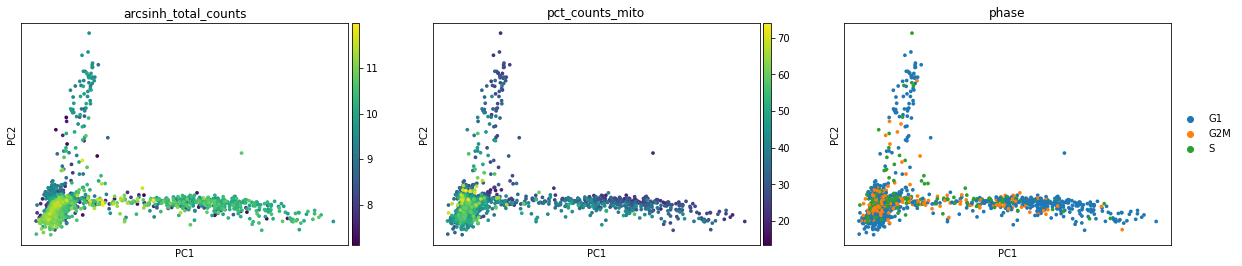

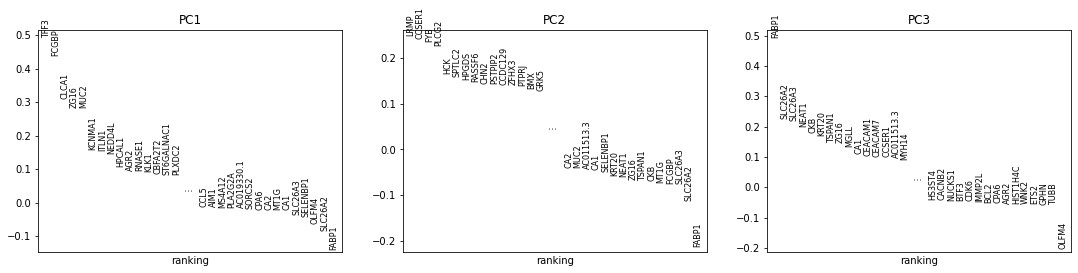

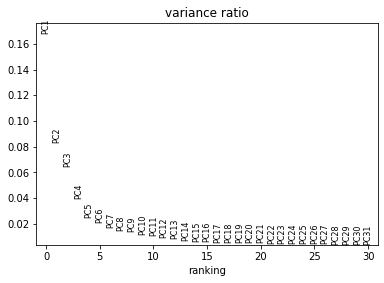

In [21]:
sc.tl.pca(adata, n_comps=50, random_state=0, use_highly_variable=True)  # perform 50-component PCA on our feature-selected dataset
sc.pl.pca_overview(
    adata,
    color=["arcsinh_total_counts","pct_counts_mito","phase"],
    color_map="viridis",
)  # view first two PCs, feature loadings, and variance

Next, we'll generate a __k-nearest neighbors (kNN)__ graph that describes similarity between all cells in our dataset based on the above 50 PCs. This graph will be used to perform unsupervised clustering and eventually generate a __UMAP__ embedding.

We choose the optimal number of nearest neighbors for graph building and __t-SNE__ analysis (perplexity) as the square-root of the total number of cells:

In [22]:
n_neighbs = int(np.sqrt(adata.n_obs))  # determine optimal number of neighbors by sqrt(n_obs)
print("Number of nearest neighbors: {}".format(n_neighbs))

Number of nearest neighbors: 46


Using the __PCA__ output above, we can generate a kNN graph and then perform graph-based __Leiden__ clustering to determine subpopulations.

In [23]:
sc.pp.neighbors(adata, n_neighbors=n_neighbs, n_pcs=50, random_state=0)  # generate kNN graph
sc.tl.leiden(adata, resolution=0.5, random_state=1)  # determine dataset clusters

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Now we can perform our favorite two-dimensional embeddings for dataset visualization.

---
### __3.__ t-SNE Embedding

Let's start with __t-SNE__, using the optimal `n_neighbs` value as the __perplexity__ parameter and beginning with all 50 principal components.

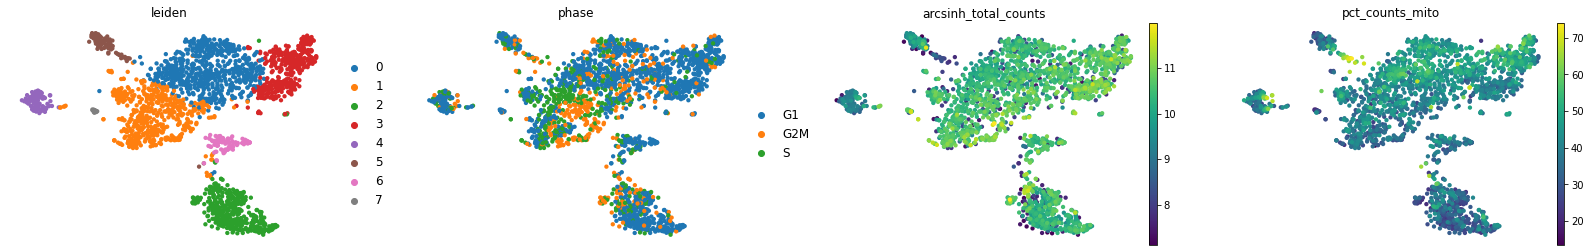

In [25]:
sc.tl.tsne(adata, use_rep="X_pca", perplexity=n_neighbs, random_state=0)  # generate t-SNE coordinates
sc.pl.tsne(
    adata,
    color=["leiden","phase","arcsinh_total_counts","pct_counts_mito"],
    legend_fontsize=12,
    legend_fontoutline=2,
    size=75,
    frameon=False,
)  # plot t-SNE with Leiden cluster overlay

---
### __4.__ PAGA

Next, we'll use **PAGA** to generate a coarse-grained graph based on the **Leiden** clusters identified for our dataset. This will be useful in generating initial positions for our __UMAP__ embedding, resulting in faster and more reliable optimization than random initialization.

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


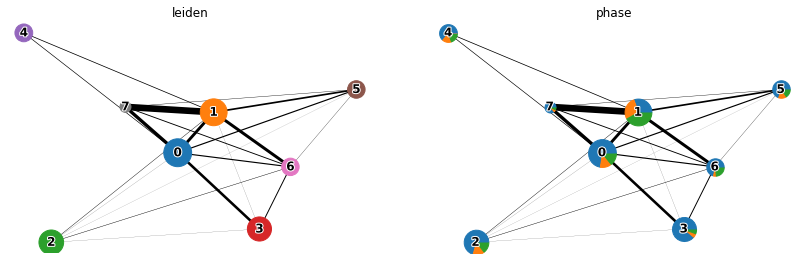

In [28]:
sc.tl.paga(adata)  # PAGA uses the kNN graph and Leiden clusters to create a cluster-cluster similarity graph
sc.pl.paga(
    adata,
    color=["leiden","phase"],
    node_size_scale=3,
    fontsize=12,
    fontoutline=2,
    frameon=False,
)  # plot PAGA graph. Edge thickness and distance describe cluster similarity

---
### __5.__ UMAP Embedding

Now, we can use **PAGA** positions and the kNN graph generated from 50 principal components to build a two-dimensional **UMAP** embedding.

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


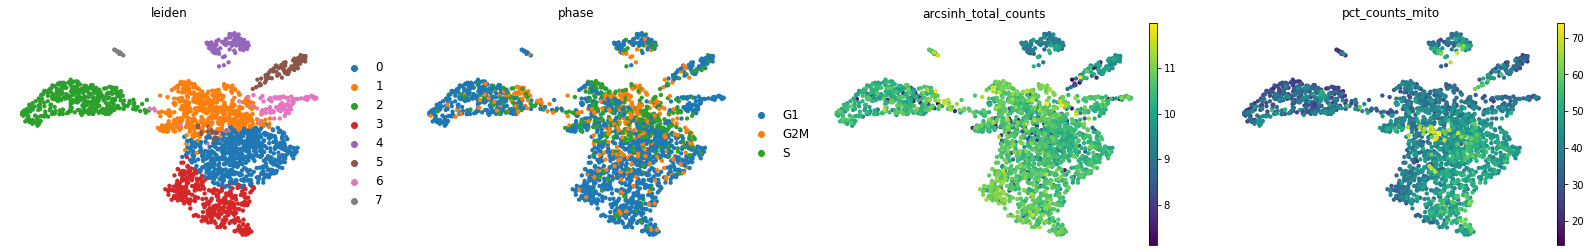

In [29]:
sc.tl.umap(adata, init_pos="paga",random_state=0)  # initialize UMAP with PAGA coordinates
sc.pl.umap(
    adata,
    color=["leiden","phase","arcsinh_total_counts","pct_counts_mito"],
    legend_fontsize=12,
    legend_fontoutline=2,
    size=75,
    frameon=False,
)  # plot embedding with Leiden cluster overlay

---
### __6.__ Differential Expression and Cell Type Inference

To identify cell types, let's perform __differential expression__ analysis and look at top genes in each cluster.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


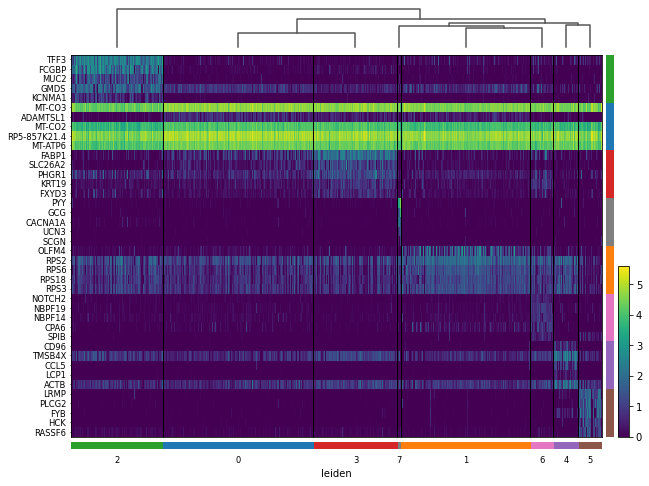

In [30]:
sc.tl.rank_genes_groups(adata, groupby="leiden")
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, cmap="viridis", swap_axes=True, show_gene_labels=True)

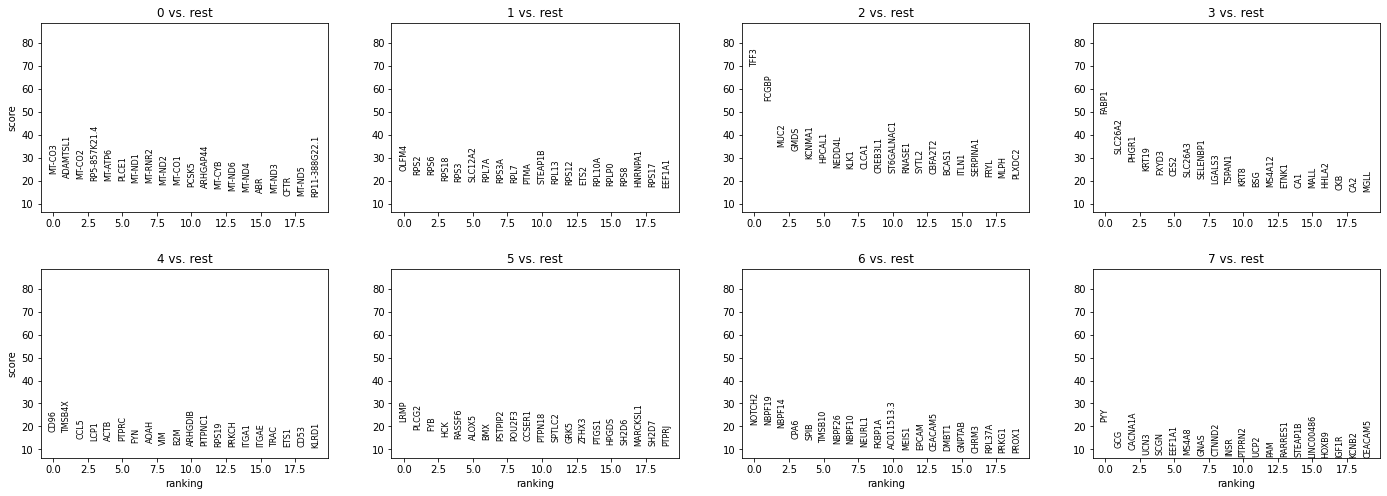

In [106]:
sc.pl.rank_genes_groups(adata)

If we are curious about the cellular identity of a particular cluster, we can blast the top DE genes against some databases:

In [97]:
import gseapy
# Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')

In [98]:
enr_res = gseapy.enrichr(gene_list=list(sc.get.rank_genes_groups_df(adata,"7").iloc[:5,]["names"]),
                     organism='Human',
                     gene_sets='Jensen_TISSUES',
                     description='pathway',
                     cutoff = 0.5)

In [99]:
enr_res.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Jensen_TISSUES,Gastrointestinal endocrine cell,2/8,0.000001,0.000148,0,0,2221.000000,29938.358472,PYY;GCG
1,Jensen_TISSUES,Hindgut,2/24,0.000014,0.000619,0,0,605.242424,6774.510368,PYY;GCG
2,Jensen_TISSUES,NCI-H226Br cell,2/33,0.000026,0.000619,0,0,429.333333,4527.427912,PYY;GCG
3,Jensen_TISSUES,Pancreatic juice,2/33,0.000026,0.000619,0,0,429.333333,4527.427912,PYY;GCG
4,Jensen_TISSUES,Enteroendocrine cell,2/35,0.000030,0.000619,0,0,403.272727,4204.515497,PYY;GCG


From the above, we can conclude that cluster `"7"` is probably comprised of enteroendocrine cells.

Now, let's label our clusters by cell type and overlay them on our UMAP embedding.

In [110]:
celltypedict = dict(zip(
    [str(x) for x in range(8)],
    ["Colonocyte","Stem","Goblet","Lymphocyte","Tuft","Quiescent","Enteroendocrine"]
))

# Remap the values of the dataframe
adata.obs["cell_type"] = adata.obs["leiden"]
adata.obs = adata.obs.replace({"cell_type" : celltypedict})

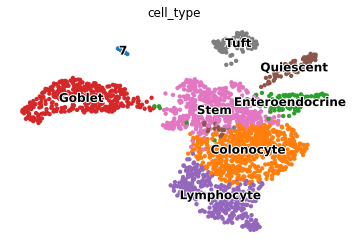

In [112]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    legend_fontsize=12,
    legend_fontoutline=2,
    size=75,
    frameon=False,
    legend_loc="on data",
)  # plot embedding with Leiden cluster overlay